# Example for audio processing

## Audio plot / cleaning

The first 2 plots show the debugging of `trim_silence` where the vertical lines show where the audio is trimmed : all part before / after are considered as `silence` to trim.

This trimming can be really useful / helpful for `Text-To-Speech (TTS)` model training.

**Note** : there is a new version of the `noisereduce` library. However, I have decided to put, by default, the old version behavior (`use_v1 = True`) as the new version has changed the behavior and is too agressive, making audios not smooth, as you can see between `cleaned` and `cleaned_v2`. 

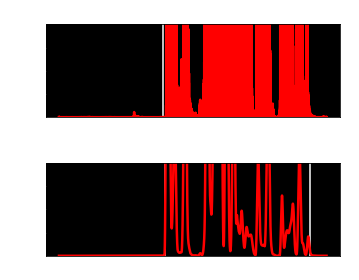

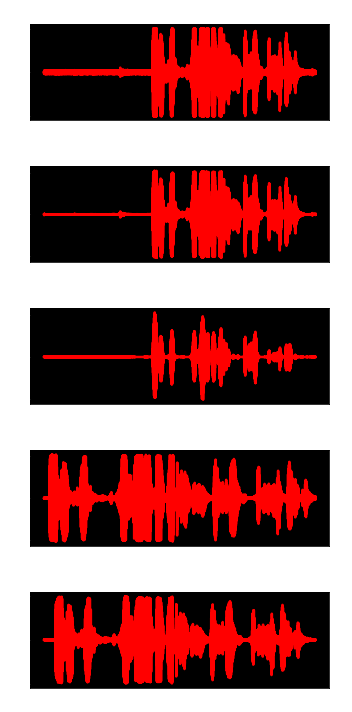

In [5]:
from utils import plot_multiple
from utils.audio import load_audio, read_audio, display_audio, trim_silence, reduce_noise

filename = 'example_data/audio_test.wav'
rate, original = read_audio(filename)

noise_reduced = reduce_noise(original, rate = rate)
noise_reduced_v2 = reduce_noise(original, rate = rate, use_v1 = False)

trimmed = trim_silence(noise_reduced, method = 'window', debug = True, plot_kwargs = {'x_size' : 5, 'y_size' : 2, 'ncols' : 1})

processed = load_audio(filename, 22050, reduce_noise = True, trim_silence = True)

plot_multiple(
    original = original, cleaned = noise_reduced, cleaned_v2 = noise_reduced_v2,
    trimmed = trimmed, processed = processed, use_subplots = True, ncols = 1, x_size = 5, y_size = 2
)

In [ ]:
_ = display_audio(original, rate = rate)
_ = display_audio(noise_reduced, rate = rate)
_ = display_audio(noise_reduced_v2, rate = rate)
_ = display_audio(trimmed, rate = rate)
_ = display_audio(processed, rate = 22050)

## Mel Spectrogram

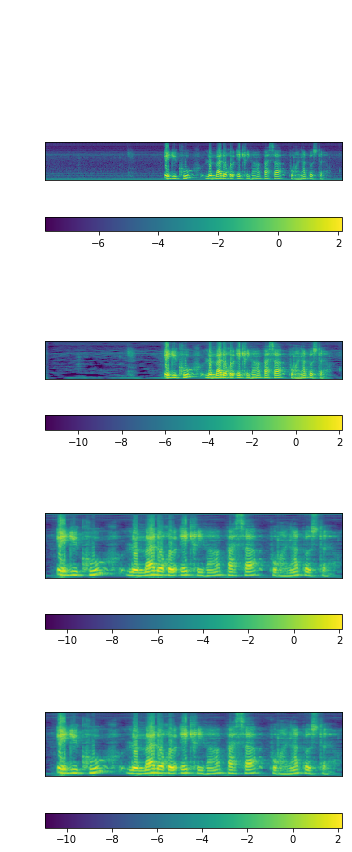

In [3]:
from utils import plot_spectrogram
from utils.audio import TacotronSTFT, load_audio, load_mel
from utils.audio import trim_silence, reduce_noise

stft = TacotronSTFT()

filename = 'example_data/audio_test.wav'
audio = load_audio(filename, stft.rate)
audio_nr = reduce_noise(audio)
audio_trimmed = trim_silence(audio_nr, method = 'window')

original = stft(audio)
noise_reduced = stft(audio_nr)
trimmed = stft(audio_trimmed)

mel = load_mel(filename, stft, reduce_noise = True, trim_silence = True)

plot_spectrogram(
    original = original, cleaned = noise_reduced, trimmed = trimmed, mel = mel,
    filename = 'example_data/plots/example_spectrogram.png', show = True
)

In [4]:
stft_filename = 'example_data/stft_config.json'

stft.save_to_file(stft_filename)
restored = TacotronSTFT.load_from_file(stft_filename)

print(stft)
print(restored)


========== TacotronSTFT ==========
filter_length	: 1024
hop_length	: 256
win_length	: 1024
n_mel_channels	: 80
sampling_rate	: 22050
mel_fmin	: 0.0
mel_fmax	: 8000.0
normalize_mode	: None


========== TacotronSTFT ==========
filter_length	: 1024
hop_length	: 256
win_length	: 1024
n_mel_channels	: 80
sampling_rate	: 22050
mel_fmin	: 0.0
mel_fmax	: 8000.0
normalize_mode	: None

